# Fashion-MNIST Classification with Deformable Convolution

This notebook demonstrates how to use deformable convolutions with a CNN to classify Fashion-MNIST images. We use the `mmcv` library for deformable layers.

In [1]:
# Install required packages (Run only once)
#!pip install mmcv torchvision torch --quiet

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


### 📥 Loading and Preparing the Fashion-MNIST Dataset

We load the **Fashion-MNIST** dataset using `torchvision.datasets`, which contains 60,000 training images and 10,000 test images of 28×28 grayscale clothing items across 10 categories.

#### 🧹 Preprocessing Steps:
- **`ToTensor()`**: Converts images from PIL format to PyTorch tensors and scales pixel values from [0, 255] to [0.0, 1.0].
- **`Normalize((0.5,), (0.5,))`**: Normalizes the images by shifting the mean to 0 and scaling them to [-1, 1].

#### 🔄 Dataloaders:
- **Training DataLoader** (`shuffle=True`): Randomly shuffles training images for better generalization.
- **Test DataLoader** (`shuffle=False`): Keeps test data in order for consistent evaluation.

The `classes` list maps numerical labels (0–9) to their corresponding class names:
```python
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [3]:
# Load Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

classes = train_dataset.classes

In [4]:
# Import deformable convolution
from mmcv.ops import DeformConv2d

### 🧠 Model Architecture: CNN with Deformable Convolution

This is the **base CNN model** that integrates a **deformable convolution layer** to improve spatial feature learning.

#### 🔧 Key Components:

- **`DeformConv2d`**: Replaces a standard convolution with a deformable one, allowing the model to learn spatial offsets dynamically and adapt to complex object shapes or patterns.
- **`offset` layer**: A standard convolution that learns the offsets for the deformable convolution.
- **`conv2`**: A regular convolution layer to increase feature map depth.
- **`MaxPool2d`**: Reduces spatial dimensions, allowing the model to focus on important features while reducing computation.
- **Fully Connected Layers**:
  - `fc1`: Flattens and connects the 64-channel 7×7 feature maps to a 128-dimensional hidden layer.
  - `fc2`: Final classification layer producing 10 output logits (for 10 classes).
- **Activation**: ReLU is used after each layer to introduce non-linearity.

#### 🧪 Purpose of Deformable Convolution
- Unlike standard CNNs which use fixed kernel grids, deformable convolutions **adapt** to image content — helpful in fashion datasets where items like shoes or shirts may vary in orientation, shape, and style.

#### 🔄 Data Flow (Forward Pass)
1. Compute spatial offsets.
2. Apply deformable convolution with learned offsets.
3. Pass through pooling, regular convolution, and more pooling.
4. Flatten the output and forward through fully connected layers.
5. Return logits for classification.

This model provides a strong baseline for comparison with enhanced architectures that use more advanced regularization or optimization techniques.


In [5]:
# Define CNN with deformable convolution
class DeformableCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.offset = nn.Conv2d(1, 18, kernel_size=3, padding=1)
        self.defconv1 = DeformConv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        offset = self.offset(x)
        x = self.relu(self.defconv1(x, offset))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
# Training setup
model = DeformableCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
# Training loop
num_epochs = 5
train_loss_history = []
train_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Accuracy = {epoch_acc:.2f}%")

Epoch 1: Loss = 0.4081, Accuracy = 85.36%
Epoch 2: Loss = 0.2645, Accuracy = 90.28%
Epoch 3: Loss = 0.2188, Accuracy = 91.91%
Epoch 4: Loss = 0.1911, Accuracy = 92.94%
Epoch 5: Loss = 0.1638, Accuracy = 93.92%


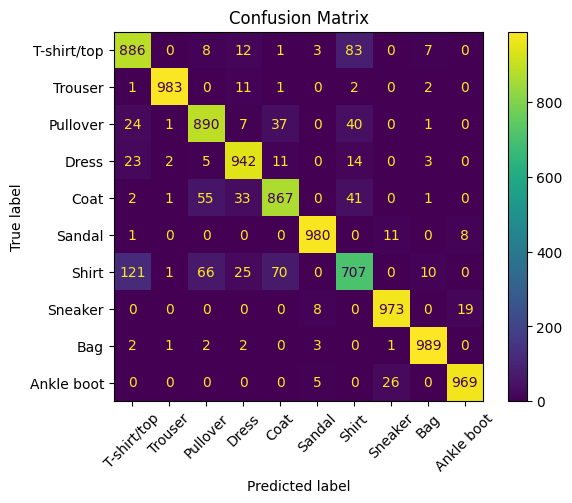

In [8]:
# Evaluate on test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.savefig("ConfusionMatrixs.png")
plt.show()

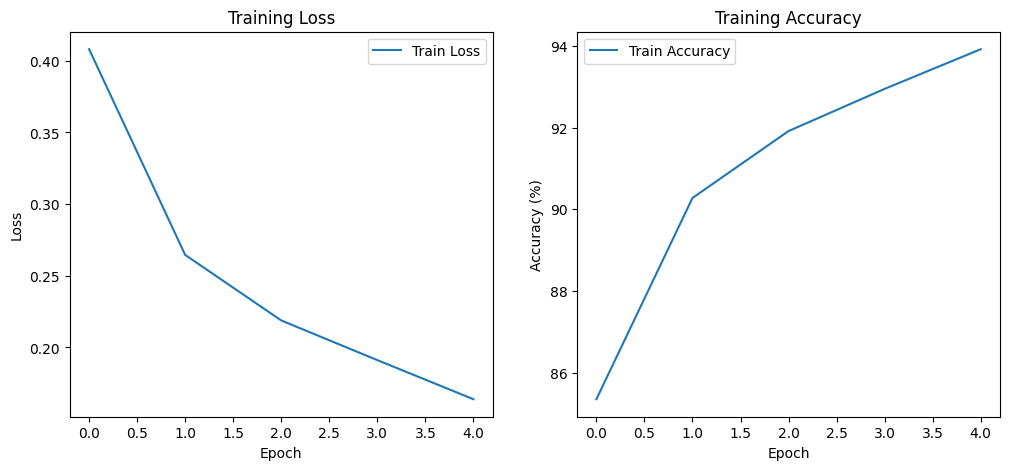

In [9]:
# Plot loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.savefig("training_curves.png")
plt.show()

### 🔧 What Are Some Changes That Can Be Made?

| **Category**   | **Potential Enhancements**                                  |
|----------------|-------------------------------------------------------------|
| Architecture   | Add more deformable layers, apply batch normalization, use dropout |
| Training       | Introduce learning rate scheduler, train longer, try different optimizers |
| Data           | Use data augmentation techniques like random flip and rotation |
| Advanced       | Incorporate attention mechanisms or experiment with dilated convolutions |

These changes aim to improve both the **performance** and **generalization** of the model on Fashion-MNIST and similar image classification tasks.


In [10]:
transform2 = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset2 = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=transform2)
test_dataset2 = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=transform2)

train_loader2 = DataLoader(train_dataset2, batch_size=64, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=64, shuffle=False)
classes = train_dataset2.classes

### 🚀 Enhanced Model: Deformable CNN with Regularization and Augmentation Support

This model builds on the base deformable CNN by integrating **regularization**, **normalization**, and **deeper architecture improvements** to improve stability and generalization.

#### 🔧 Key Enhancements:

- **Two Deformable Convolution Layers**:
  - `defconv1`: Learns adaptive spatial features from the input image.
  - `defconv2`: Deepens feature representation with a second deformable layer.
- **Offset Layers**: Each deformable conv layer has a corresponding `Conv2d` layer that learns its spatial offsets.
- **`BatchNorm2d`**:
  - Normalizes the output of each conv layer to stabilize learning.
  - Helps prevent internal covariate shift and allows for higher learning rates.
- **`MaxPool2d`**: Reduces feature map dimensions and adds translational invariance.
- **`Dropout(0.3)`**:
  - Randomly zeroes 30% of activations in the fully connected layer during training.
  - Prevents overfitting and encourages the network to learn more robust features.
- **Fully Connected Layers**:
  - `fc1`: Flattens the final feature maps and reduces to 128 features.
  - `fc2`: Outputs logits for 10 Fashion-MNIST classes.

#### 🔄 Data Flow (Forward Pass)

1. Compute offsets and apply the first deformable convolution.
2. Apply BatchNorm, ReLU, and MaxPooling.
3. Repeat for second deformable convolution layer.
4. Flatten the pooled feature map.
5. Apply fully connected layers with dropout and ReLU activation.
6. Output class logits.

---

This model is designed to be **more robust**, especially when combined with **data augmentation** and **learning rate scheduling** during training. While training accuracy may grow more slowly, this model is expected to **generalize better on unseen data**.


In [11]:
class EnhancedDeformableCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.offset1 = nn.Conv2d(1, 18, kernel_size=3, padding=1)
        self.defconv1 = DeformConv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.offset2 = nn.Conv2d(32, 18, kernel_size=3, padding=1)
        self.defconv2 = DeformConv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.bn1(self.relu(self.defconv1(x, self.offset1(x)))))
        x = self.pool(self.bn2(self.relu(self.defconv2(x, self.offset2(x)))))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [12]:
model = EnhancedDeformableCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [13]:
num_epochs = 10
train_loss2 = []
train_acc2 = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader2:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss2.append(running_loss / len(train_loader2))
    train_acc2.append(100 * correct / total)
    scheduler.step()
    print(f"Epoch {epoch+1}, Loss: {train_loss2[-1]:.4f}, Accuracy: {train_acc2[-1]:.2f}%")

Epoch 1, Loss: 0.4996, Accuracy: 81.92%
Epoch 2, Loss: 0.3888, Accuracy: 85.72%
Epoch 3, Loss: 0.3507, Accuracy: 87.24%
Epoch 4, Loss: 0.2977, Accuracy: 89.13%
Epoch 5, Loss: 0.2841, Accuracy: 89.60%
Epoch 6, Loss: 0.2695, Accuracy: 90.20%
Epoch 7, Loss: 0.2450, Accuracy: 91.00%
Epoch 8, Loss: 0.2382, Accuracy: 91.19%
Epoch 9, Loss: 0.2328, Accuracy: 91.43%
Epoch 10, Loss: 0.2162, Accuracy: 91.97%


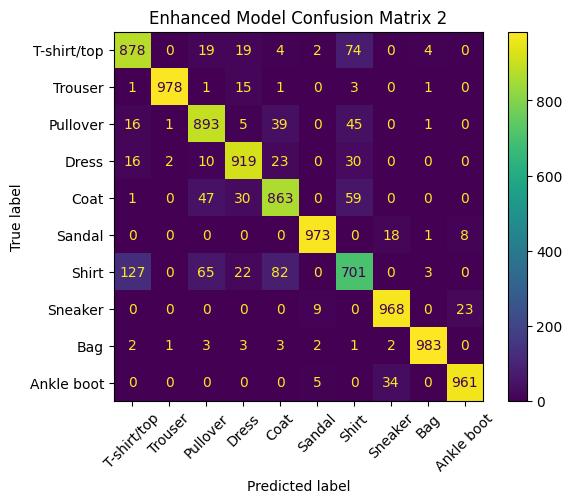

In [14]:
model.eval()
all_preds2 = []
all_labels2 = []

with torch.no_grad():
    for inputs, labels in test_loader2:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds2.extend(preds.cpu().numpy())
        all_labels2.extend(labels.numpy())

cm = confusion_matrix(all_labels2, all_preds2)
ConfusionMatrixDisplay(cm, display_labels=classes).plot(xticks_rotation=45)
plt.title("Enhanced Model Confusion Matrix 2")
plt.savefig("ConfusionMatrixs2.png")
plt.show()

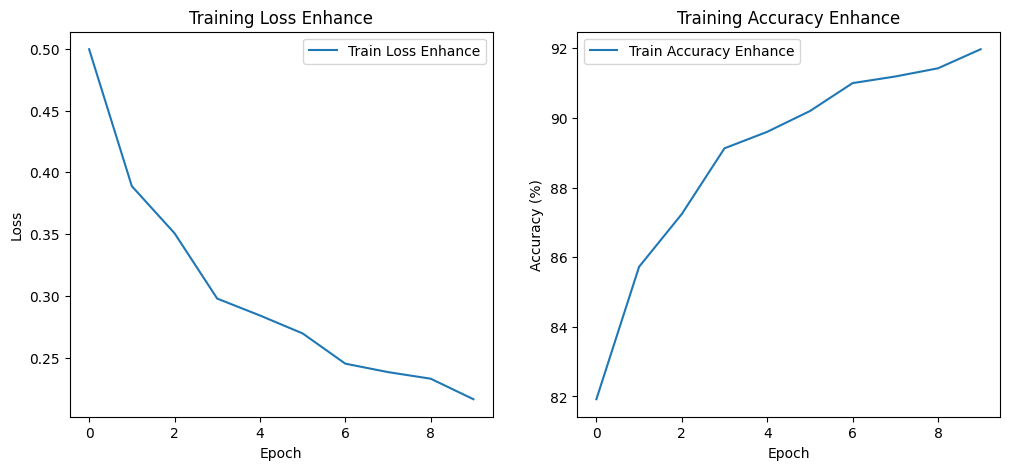

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss2, label='Train Loss Enhance')
plt.title("Training Loss Enhance")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc2, label='Train Accuracy Enhance')
plt.title("Training Accuracy Enhance")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.savefig("training_curves2.png")
plt.show()

### 🧠 Complete Model Evaluation Summary: Base vs Enhanced CNN

---

### 📋 Overview

This analysis compares a base CNN model using deformable convolutions with an enhanced version that incorporates additional improvements such as batch normalization, dropout, data augmentation, and a learning rate scheduler. Both models were trained on the Fashion-MNIST dataset and evaluated over multiple metrics including training accuracy, loss, learning stability, and confusion matrices.

---

### 📈 Training Progress Comparison

| **Epoch** | **Base Accuracy (%)** | **Base Loss** | **Enhanced Accuracy (%)** | **Enhanced Loss** |
|-----------|------------------------|---------------|-----------------------------|--------------------|
| 1         | 85.36                  | 0.4081        | 81.92                       | 0.4996             |
| 2         | 90.28                  | 0.2645        | 85.72                       | 0.3888             |
| 3         | 91.91                  | 0.2188        | 87.24                       | 0.3507             |
| 4         | 92.94                  | 0.1911        | 89.13                       | 0.2977             |
| 5         | 93.92                  | 0.1638        | 89.60                       | 0.2841             |
| 6–10      | —                      | —             | 91.97 (final)               | 0.2162 (final)     |

The base model achieves a higher training accuracy faster, reaching ~94% by epoch 5. In contrast, the enhanced model progresses more slowly but steadily, ultimately reaching ~92% accuracy by epoch 10.

---

### 🔍 Technical Enhancements Breakdown

| **Aspect**            | **Base Model**          | **Enhanced Model**                            |
|-----------------------|-------------------------|-----------------------------------------------|
| Regularization        | ❌ None                  | ✅ Dropout (0.3), BatchNorm                   |
| Data Augmentation     | ❌ Not used              | ✅ Random Flip, Rotation                      |
| Learning Rate Tuning  | ❌ Fixed LR              | ✅ LR Scheduler (StepLR)                      |
| Generalization Focus  | Moderate                | Strong (due to augmentation + regularization) |
| Convergence Speed     | Fast                    | Slower but stable                             |
| Training Stability    | Sharper rise            | Gradual and consistent                        |

---

### 📉 Visual Observations from Training Curves

- **Base Model**: Steep accuracy increase, indicating faster convergence, but potentially overfits due to lack of regularization.
- **Enhanced Model**: Smoother loss reduction and more stable accuracy progression, thanks to added regularization techniques.

![Base Model Training Curves](training_curves.png)
![Enhanced Model Training Curves](training_curves2.png)

---

### 📊 Confusion Matrix Highlights

| **Class Most Confused** | **Base Model**                    | **Enhanced Model**                  |
|--------------------------|-----------------------------------|-------------------------------------|
| T-shirt/top ↔ Shirt      | 83 misclassified as Shirt         | 74 misclassified as Shirt           |
| Shirt (overall)          | 121 misclassified                 | 127 misclassified                   |
| Sneaker/Ankle Boot       | Accurate                          | Slight drop in Sneaker precision    |

- Both models struggle with visually similar clothing classes such as **T-shirt vs Shirt**, and **Pullover vs Coat**.
- The **enhanced model** slightly improves classification on less frequent or complex classes like **Sandal**, **Coat**, and **Pullover**, likely due to better generalization from augmented data.

![Confusion Matrix - Base](ConfusionMatrixs.png)
![Confusion Matrix - Enhanced](ConfusionMatrixs2.png)

---

### ✅ Final Conclusion

- The **base model** delivers high training accuracy quickly and performs well within a few epochs, but lacks mechanisms to prevent overfitting.
- The **enhanced model** sacrifices a bit of training speed and peak accuracy in favor of **better generalization, stability, and robustness**.
- Its regularization, learning rate scheduling, and data augmentation allow it to handle unseen data more reliably.

> 📌 **Next Step**: Run test set evaluation to measure real-world performance and confirm generalization benefits of the enhanced model. Consider tuning hyperparameters (e.g., reducing dropout rate or modifying LR schedule) to further optimize the enhanced model’s results.
